# <center>Porównanie schematów Eulera-Maruyamy oraz Milsteina dla modelu GBM do predykcji cen akcji.</center>
***
<center><i>Jędrzej Sarna 05.07.2023 r.</i></center>

Celem pracy jest porównanie schematów Eulera-Maruyamy oraz Milsteina dla modelu geometrycznego ruchu Browna. Dla praktycznego zostosowania, cała analiza zostanie oparta na notowaniach akcji AAPL w latach 2015-2020. Dodatkowo, poddamy ocenie opracowany model, przeprowadzając predykcję cen akcji rok do przodu, a następnie porównując wyniki z rzeczywistymi danymi.

## 1. Przygotowanie i eksploracja danych

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Wykonac komorke tylko raz! Wynika to z nadpisana kolumny, wyjasnione w tej komorce ponizej
AAPL = pd.read_csv("AAPL.csv")

AAPL = AAPL.drop(columns=['divCash','splitFactor','Unnamed: 0','adjClose', 'adjHigh', 'adjLow', 'adjOpen', 'adjVolume'])
AAPL['date'] = pd.to_datetime(AAPL['date']).dt.date
AAPL['close']=AAPL['close']/4 #mozliwe ze inna waluta niz dolary, zostalo sprawdzone i 4-krotnie wieksze od rzeczywistej ceny w dolarach

In [3]:
AAPL

,symbol,date,close,high,low,open,volume
0,AAPL,2015-05-27,33.01125,132.260,130.0500,130.34,45833246
1,AAPL,2015-05-28,32.94500,131.950,131.1000,131.86,30733309
2,AAPL,2015-05-29,32.57000,131.450,129.9000,131.23,50884452
3,AAPL,2015-06-01,32.63375,131.390,130.0500,131.20,32112797
4,AAPL,2015-06-02,32.49000,130.655,129.3200,129.86,33667627
...,...,...,...,...,...,...,...
1253,AAPL,2020-05-18,78.74000,316.500,310.3241,313.17,33843125
1254,AAPL,2020-05-19,78.28500,318.520,313.0100,315.03,25432385
1255,AAPL,2020-05-20,79.80750,319.520,316.2000,316.68,27876215
1256,AAPL,2020-05-21,79.21250,320.890,315.8700,318.66,25672211


Będziemy przewidywać cenę <i>'close price'</i>, gdyż jest ona najczęściej przewidywaną zmienną przy predykcji cen akcji. Odzwierciedla ona ogólny nastrój rynkowy i uwzględnia skumulowane skutki całej działalności handlowej, która miała miejsce w ciągu dnia.

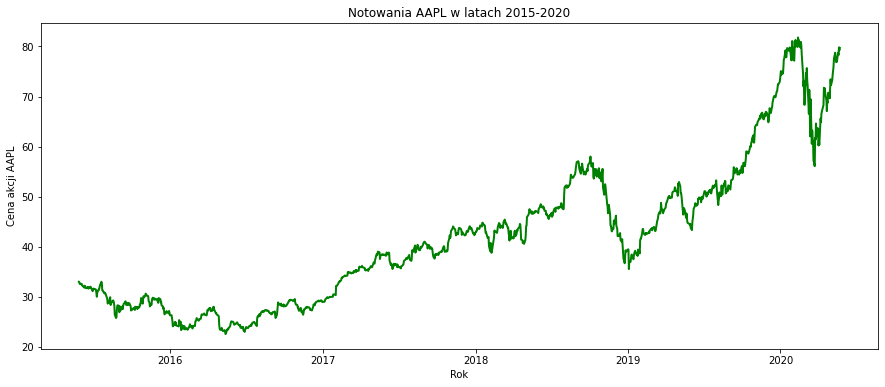

In [5]:
plt.rcParams['figure.figsize'] = (15,6)
plt.rcParams['lines.linewidth'] = 3

plt.plot(AAPL['date'], AAPL['close'], color='green', linewidth=2)
plt.xlabel("Rok")
plt.ylabel("Cena akcji AAPL")
plt.title("Notowania AAPL w latach 2015-2020")
plt.show()

## 2. Zdefiniowanie modelu

Do modelowania posłuży nam proces stochastyczny nazywany Geometrycznym Ruchem Browna. Wykorzystanie tego procesu ma szczególne uzasadnienie w przypadku, gdy zmienną stanu jest instrument finansowy notowany na giełdzie, taki jak akcje, 
dla których jest obserwowany eksponencjalny (co widać na wykresie powyżej) wzrost wartości.
<br>
<br>
Dany jest on następującym wzorem:<br>
<center>$dX(t) = \mu X(t) dt + \sigma X(t) dW(t)$,</center>
gdzie:<br>
$W_t$ - proces Wienera,<br>
$X_t$ - zmienna stanu,<br>
$\mu$ - dryf procesu, $\mu \in \mathbb{R}$,<br>
$\sigma$ - zmienność procesu, $\sigma>0$.
<br>
<br>
Zatem należy podjąć się estymacji parametrów $\mu$ oraz $\sigma$.

Znane jest rozwiązanie dokładne dla geometrycznego ruchu Browna i jest postaci:<br>
<center>$X(t) = X(0)e^{(\mu-\frac{1}{2}\sigma^2)t+\sigma W(t)}$</center>
<br>
Dla $X(t)>0$ mamy: <br>
<center>$ln(X(t)) = ln(X(0))+(\mu-\frac{1}{2}\sigma^2)t+\sigma W(t)$</center> <br>
i dla $k = 1,2, ... ,$ : <br>
<center>$ln(X(t_k)) - ln(X(t_{k-1})) = (\mu-\frac{1}{2}\sigma^2)(t_k - t_{k-1})+\sigma (W(t_k)-W(t_{k-1})),$</center> <br>
gdzie $(W(t_k)-W(t_{k-1})) \sim \mathcal{N}(0,t_k - t_{k-1})$, więc :<br>
<br>
<center>$ln(X(t_k)) - ln(X(t_{k-1})) \sim \mathcal{N}((\mu-\frac{1}{2}\sigma^2)(t_k - t_{k-1}), \sigma^2 (t_k-t_{k-1}))$</center> <br>
dla dyskretnych punktów $t_k$. <br>
<br>
Wartość oczekiwana oraz wariancja $X(t)$ wynoszą odpowiednio:
<br>
$E[X(t)] = X(0)e^{\mu t}$
<br>
$Var[X(t)] = X^2(0)e^{2\mu t}(e^{\sigma^2 t}-1)$
<br>
<br>
Aby zasymulować ten proces, ciągłe równanie między dyskretnymi chwilami $t_0 < t_1 < ... < t_n$ należy rozwiązać w następujący sposób:
<br>
<br>
<center>$X(t_k) = X(t_{k-1})e^{(\mu-\frac{1}{2}\sigma^2)(t_k-t_{k-1})+\sigma \sqrt{t_k-t_{k-1}}Z_k}$</center> <br>
gdzie $Z_1, Z_2, ...Z_n$ są niezależnymi losowaniami ze standardowego rozkładu normalnego.

## Estymacja parametrów

Przypominając, parametry do oszacowania to $\theta = (\mu, \sigma)$ w procesie GBM. Ponieważ GBM jest procesem ciągłym w czasie, uzyskane zostaną przybliżone wartości metodą największej wiarygodności na podstawie dyskretnych obserwacji.
<br>
<br>
Najpierw ustalmy $x(t_k) := ln(X(t_k)) - ln(X(t_{k-1}))$. Przy istniejącej niezależności oraz normalności zmiennej $x(t_k)$ (co pokazane powyżej) funkcja wiarygodności jest dana przez:
<br>
<br>
<center>$L(\theta) = \sum_{k=1}^{n} ln(f_{\theta}(x(t_k))),$</center>gdzie gęstość $f_{\theta}$ wyraża się wzorem:
<br>
<br>
$$f_{\theta}(x(t_k))=\frac{1}{X(t_k) \sigma \sqrt{2\pi(t_k-t_{k-1})}}exp\left(-\frac{[x(t_k)-(\mu -\frac{1}{2}\sigma^2)(t_k-t_{k-1})]^2}{2\sigma^2(t_k-t_{k-1})}\right).$$
<br>
Aby określić $\theta$, weźmy $\Delta t := t_k-t_{k-1}$. Wartość oczekiwana oraz wariancja dla takiego rozkładu to odpowiednio:
<br>
$\hat{m} := (\hat{\mu} -\frac{1}{2}\hat{\sigma}^2) \Delta t$
<br>
$\hat{v} := \sigma^2 \Delta t$
<br>
<br>
Oszacowania parametrów GBM są następnie wyprowadzane z oszacowań $m$ i $v$. Aby uzyskać wyrażenie w postaci jawnej dla parametrów $m$ i $v$, należy policzyć pochodną gęstości względem tych parametrów i przyrównać do zera, co daje:
<br>
$\hat{m} = \sum_{k=1}^{n} \frac{x(t_k)}{n},$
<br>
$\hat{v} = \sum_{k=1}^{n} \frac{(x(t_k)-\hat{m})^2}{n}.$
<br>
<br>
Zatem ostatecznie estymowane parametry modelu mają następującą postać:
<br>
$\hat{\mu} = \frac{\hat{m}}{\Delta t} + \frac{1}{2}\hat{\sigma}^2$
<br>
$\hat{\sigma}^2 = \frac{\hat{v}}{\Delta t}$

## Wyliczenie parametrów dla naszych danych

In [6]:
def calculate_log_returns(prices):
    log_returns = np.log(prices / prices.shift(1))
    return log_returns

log_returns = calculate_log_returns(AAPL['close'])

average_return = log_returns.mean()
volatility = log_returns.var()

print(average_return, volatility)

0.000701434719292725 0.000329770420315876


Dla nas $\Delta t = 1$.

In [8]:
sigma_squared = volatility
drift = average_return + 0.5*sigma_squared
sigma = np.sqrt(sigma_squared)
print(drift, sigma_squared, sigma)

0.0008663199294506631 0.000329770420315876 0.018159582052345698


Przypomnijmy postać rozwiązania dokładnego dla geometrycznego Ruchu Browna:<br>
<center>$X(t) = X(0)e^{(\mu-\frac{1}{2}\sigma^2)t+\sigma W(t)}.$</center>
<br>
Zatem dla wyestymowanych parametrów przyjmuje postać:
<center>$X(t) = X(0)e^{0.0007 t+ 0.0182 W(t)}.$</center>

Przejdźmy do symulacji trajektorii.

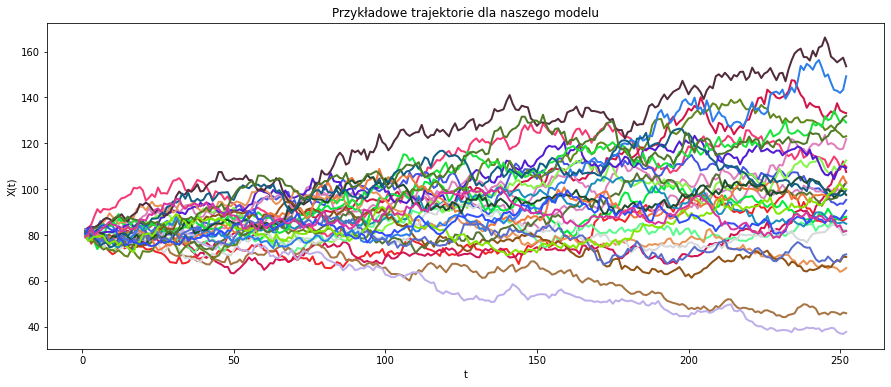

In [9]:
plt.rcParams['figure.figsize'] = (15,6)
plt.rcParams['lines.linewidth'] = 2

#kolory do wykreslania trajektorii
import random
get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
pal = get_colors(30)


# Parametry modelu
X0 = AAPL['close'].iloc[-1]
sigma = sigma
drift = drift
# Parametry do symulacji
T = 252
N = 252
dt = T / N
t = np.arange(dt, T+dt, dt)  # zaczynamy na dt bo X=X0 dla t=0

plt.title('Przykładowe trajektorie dla naszego modelu')
plt.xlabel('t')
plt.ylabel('X(t)')

for i in range(len(pal)):
    
    # proces Wienera
    np.random.seed(i)
    dW = np.sqrt(dt) * np.random.randn(N)
    W  = np.cumsum(dW)
    
    # Wyliczenie dokładnego rozwiazania
    X = X0 * np.exp((drift - 0.5 * sigma**2)*t + sigma * W)
    plt.plot(t, X, color=pal[i])

Powyższy wykres pokazuje, że wartości $X(t)$ dla danego $t$ różni się w różnych przykładowych trajektoriach (ponieważ jest to zmienna losowa).

Poniżej symulujemy 10 000 przykładowych trajektorii, a na wykresie po lewej stronie pokazujemy pierwsze 200 z nich. Wykres po prawej stronie zostanie za chwilę dokładniej omówiony.

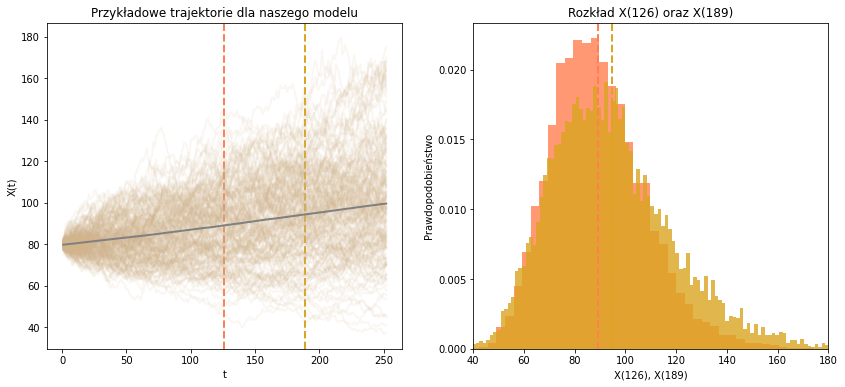

In [10]:
# Wykres przykladowych trajektorii oraz sredniej trajektorii 
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(121)
plt.xlabel('t')
plt.ylabel('X(t)') 
plt.title('Przykładowe trajektorie dla naszego modelu')

#Pionowe linie
plt.axvline(x=0.50*N, linestyle='--', color="coral")
plt.axvline(x=0.75*N, linestyle='--', color="goldenrod")

# Symulacja trajektorii
X_1, X_2, X_total = [], [], []
for i in range(10000):
    
    # proces Wienera
    np.random.seed(i)
    dW = np.sqrt(dt) * np.random.randn(N)
    W  = np.cumsum(dW)
    
    # Wyliczenie dokładnego rozwiazania
    X = X0 * np.exp((drift - 0.5 * sigma**2) * t + sigma * W)
    X_1.append(X[int(0.50 * N)])
    X_2.append(X[int(0.75 * N)])
    X_total.append(X)
    
    # Rysujemy tylko 200 pierwszych dla czytelnosci
    if i < 200:
        ax.plot(t, X, color="tan", alpha=0.1)

# Srednia trajektoria
ax.plot(t, np.mean(X_total, axis = 0), color="gray")

fig.add_subplot(122)
plt.xlabel('X(126), X(189)')
plt.ylabel('Prawdopodobieństwo')
plt.xlim(40,180)
plt.title('Rozkład X(126) oraz X(189)')
plt.hist(X_1,color="coral", bins=50, density=1, alpha=0.8)
plt.hist(X_2,color="goldenrod", bins=150, density=1, alpha=0.8)
plt.axvline(np.mean(X_total, axis = 0)[int(0.50 * N)],linestyle='--',color="coral")
plt.axvline(np.mean(X_total,axis = 0)[int(0.75 * N)],linestyle='--',color="goldenrod")
plt.show()

 Podobnie jak wcześniej, widzimy, że wartość $X(t)$ znacznie się różni dla różnych trajektorii, a także zaczynamy wyraźniej widzieć, że istnieje rozkład powiązany z każdym punktem $t$. Wydaje się, że średnia rośnie (co potwierdza szara linia, która przedstawia średnią wartość $X(t)$ w każdym punkcie), a rozpiętość rozkładu również wydaje się rosnąć.

Dodatkowo zostały narysowane pionowe linie przy $t=126 =(252 \cdot 0,5)$, zatem w punkcie określającym "połowę" przewidywanego okresu i $t=189 =(252 \cdot 0,75)$ określającym odpowiednio $75\%$. Wykres po prawej stronie tworzy histogramy powiązanych wartości $X(t)$ w tych przekrojach. Widzimy, że histogram odpowiadający rozkładowi $X(189)$ jest lekko przesunięty na prawo w stosunku do histogramu odpowiadającemu rozkładowi $X(126)$. Dwie pionowe linie przedstawiające ich odpowiednie średnie również potwierdzają wyższą średnią wartość dla $X(189)$. Widzimy również, że $X(189)$ ma większą wariancję - wraz ze wzrostem $t$ jest więcej "miejsca" na dalsze oddalanie się procesu Wienera.

In [11]:
def calculate_linear_function(x1, y1, x2, y2):
    # nachylenie
    m = (y2 - y1) / (x2 - x1)
    
    # wyraz wolny
    b = y1 - m * x1
    return f"y = {m}x + {b}"

#funkcje liniowe srednich
mean_tbl = np.mean(X_total, axis = 0)
print("Funkcja liniowa średniej na przyszły rok:         ", calculate_linear_function(1, mean_tbl[0], 252, mean_tbl[-1]))

print("Funkcja liniowa średniej notowań historycznych:   ", calculate_linear_function(0, AAPL['close'][0], 1257, AAPL['close'][1257]))

Funkcja liniowa średniej na przyszły rok:          y = 0.07893534039361882x + 79.73600293746327
Funkcja liniowa średniej notowań historycznych:    y = 0.03716089896579157x + 33.01125


Powyżej zostały obliczone dwie funkcje przedstawiające średni wzrost cen akcji dla naszych notowań historycznych (obliczone w najprostszy sposób, licząc funkcję liniową na podstawie pierwszego i ostatniego notowania w dostępnych danych) oraz średni wzrost cen na przyszły rok, przedstawiony już na rysunku powyżej. Widzimy, że w tym przypadku, średni wzrost cen na przyszły rok jest znacznie większy niż przez ostatnie 5 lat, co wydaje się być sensownym wynikiem, patrząc na zachowania cen w ostatnich latach zebranych danych (duży wzrost).

## Aproksymacja

Niestety, większość stochastycznych równań różniczkowych nie ma rozwiązań jawnych, więc nie możemy po prostu symulować rozwiązań takich jak powyżej. Dlatego zwykle musimy przybliżyć $X(t)$. W tej pracy zostaną przedstawione dwie najpopularniejsze metody aproksymacji numerycznej - metoda Eulera-Maruyamy oraz metoda Milsteina. Będziemy nadal koncentrować się na powyższym modelu geometrycznego ruchu Browna, mimo że tak naprawdę nie musimy go aproksymować. Jego dokładne rozwiązanie posłuży nam do oceny dokładności naszych metod aproksymacji. Przez cały czas będziemy oznaczać przybliżenie $X(t)$ jako $S(t)$.

## Schemat Eulera-Maruyamy

Przypomnijmy, że geometryczny ruch Browna możemy zapisać za pomocą postaci całkowej w następujący sposób:
$$X(t_{k+1})-X(t_k) = \mu  \int_{t_k}^{t_{k+1}} X(s) \,ds + \sigma \int_{t_k}^{t_{k+1}} X(s) \,dW(s)$$
<br>
Najprostszym przybliżeniem tego jest metoda Eulera-Murayamy, która jest stochastycznym uogólnieniem standardowej metody Eulera dla równań różniczkowych zwyczajnych.
<br>
$$S(t_{k+1})-S(t_k) = \mu S(t_k) \Delta t_k + \sigma S(t_k) \Delta W(t_k)$$
<br>
Wynika to intuicyjnie, jeśli pomyślimy, że pierwsza całka jest aproksymowana przez $\mu S(t_k) \Delta t_k$ oraz druga przez $\sigma S(t_k) \Delta W(t_k)$, chociaż formalne wyprowadzenie opiera się na rozwinięciu Taylora. Poniżej zaczynamy od symulacji pojedynczej trajektorii dla dokładnego rozwiązania $X(t)$ i odpowiadającą trajektorię dla przybliżeń Eulera-Maruyamy przy użyciu dwóch różnych wartości $\Delta t$. Wybieramy duże $\Delta t$ jako dokładne wielokrotności mniejszego, aby móc ocenić procesy w tych samych punktach.

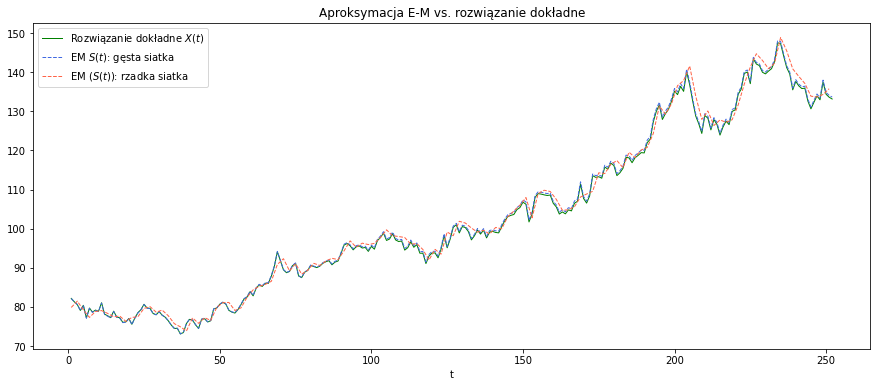

In [14]:
# proces Wienera
np.random.seed(1)
dW = np.sqrt(dt) * np.random.randn(N)
W  = np.cumsum(dW)

# Wyliczenie dokładnego rozwiazania
X = X0 * np.exp(((drift - 0.5 * sigma**2) * t) + (sigma * W))

# Aproksymacja EM, małe dt
S_em_small =[]
S = X0
for j in range(N):  
    S += drift * S * dt + sigma * S * dW[j]
    S_em_small.append(S)

# Aproksymacja EM, duże dt
S_em_big =[]
S = X0
R = 2
grid = np.arange(dt,T+dt,R*dt)

for j in range(int(N/R)):
    S += drift * S * (R * dt) + sigma * S * sum(dW[R*(j-1):R*j])
    S_em_big.append(S)    

plt.rcParams['lines.linewidth'] = 1
plt.plot(t, X, label="Rozwiązanie dokładne $X(t)$", color='green')
plt.plot(t, S_em_small, label="EM $S(t)$: gęsta siatka", color='royalblue', ls='--')
plt.plot(grid, S_em_big, label="EM ($S(t)$): rzadka siatka", color='tomato', ls='--')
plt.title('Aproksymacja E-M vs. rozwiązanie dokładne')
plt.xlabel('t')
plt.legend(loc = 2)
plt.show()

Powyższy wykres sugeruje, że przybliżenie E-M działa całkiem dobrze oraz staje się „lepsze” (bliższe dokładnemu rozwiązaniu), gdy zmniejszymy rozmiar kroku $\Delta t$.

## Schemat Milsteina

Metoda Milsteina zwiększa dokładność przybliżenia E-M poprzez dodanie składnika „korekty” drugiego rzędu, który pochodzi ze stochastycznego rozwinięcia $X(t)$ w szereg Taylora stosując lemat Ito do $a()$ oraz $b()$. Zatem metoda Milsteina daje następującą postać różniczkową:
<br>
<br>
$$
S(t_{k+1}) - S(t_k) = a(S(t_k))\Delta t + b(S(t_k))\Delta W(t_k) \color{red}{+ 0.5b'(S(t_k))b(S(t_k))\left((\Delta W(t_k))^2-\Delta t\right)}
$$
<br>
co implikuje dla naszego przykładu geometrycznego ruchu Browna postać:
<br>
<br>
$$
S(t_{k+1}) - S(t_k) = a(S(t_k))\Delta t + b(S(t_k))\Delta W(t_k) \color{red}{+ 0.5\sigma^2 X(t_k)\left((\Delta W(t_k))^2-\Delta t\right)}
$$

Poniżej symulujemy pojedynczą ścieżkę dla schematu Milsteina, używając tego samego losowania co wcześniej i nanosimy na wykres z dokładnym rozwiązaniem i przybliżeniem E-M.

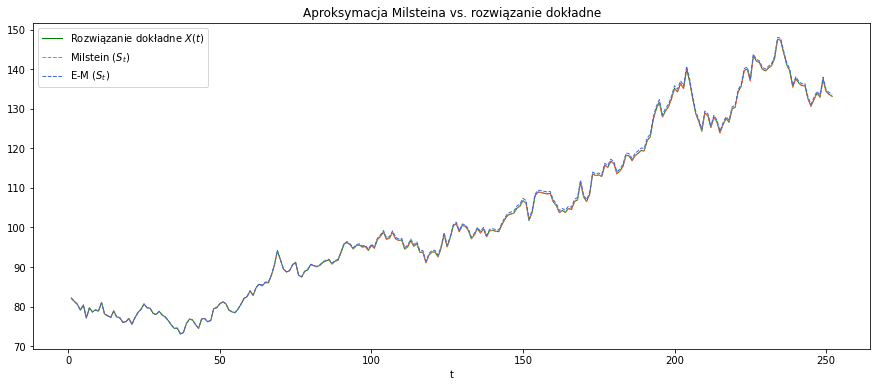

In [15]:
# Aproksymacja Milsteina
S_mil = []
S = X0
for j in range(N):  
    S += drift * S * dt + sigma * S * dW[j] + 0.5 * sigma**2 * S * (dW[j] ** 2 - dt)
    S_mil.append(S)
    
plt.rcParams['lines.linewidth'] = 1
plt.plot(t, X, label="Rozwiązanie dokładne $X(t)$",color='green')
plt.plot(t, S_mil, label="Milstein ($S_t$)",color='tomato',ls='--')
plt.plot(t, S_em_small, label="E-M ($S_t$)",color='royalblue',ls='--')
plt.title('Aproksymacja Milsteina vs. rozwiązanie dokładne')
plt.xlabel('t')
plt.legend(loc=2)
plt.show()

Na tym wykresie nie widać zbytnio różnic między aproksymacjami. Aby lepiej dostrzec różnice, zróbmy "powiększenie" dla pewnego fragmentu wykresu.

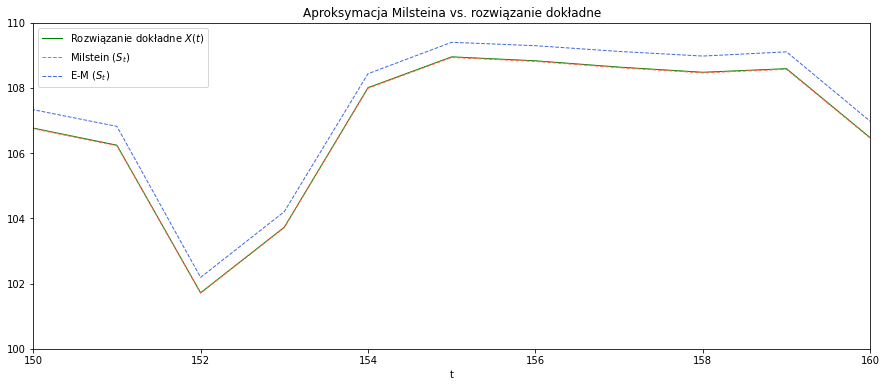

In [16]:
plt.rcParams['lines.linewidth'] = 1
plt.plot(t, X, label="Rozwiązanie dokładne $X(t)$",color='green')
plt.plot(t, S_mil, label="Milstein ($S_t$)",color='tomato',ls='--')
plt.plot(t, S_em_small, label="E-M ($S_t$)",color='royalblue',ls='--')
plt.title('Aproksymacja Milsteina vs. rozwiązanie dokładne')
plt.xlabel('t')
plt.legend(loc=2)
plt.xlim(150,160)
plt.ylim(100,110)
plt.show()

Widzimy, że linia aproksymacji Milsteina wydaje się być bliższa niż odpowiadająca jej aproksymacja E-M. Istnieje wiele sposobów formalnego zdefiniowania, co mamy na myśli, gdy mówimy, że jeden proces stochastyczny jest bliski drugiemu. Przejdźmy do jednej z nich.

Pojęcie zbieżności formalizuje, co to znaczy, że jeden proces stochastyczny zbliża się do drugiego w miarę zmniejszania się wielkości kroku $\Delta t$. Istnieje wiele różnych definicji zbieżności, ale dwie najpowszechniejsze to „słaba zbieżność” i „silna zbieżność”. Dla słabej zbieżności definiujemy następujący błąd

$$
e^w(\Delta t) = \sup_{t_k}|E(S(t_k)) - E(X(t_k))|
$$

natomiast dla silnej zbieżności definiujemy

$$
e^s(\Delta t) = \sup_{t_k} E(|S(t_k) - X(t_k)|)
$$

Terminy te są również często definiowane alternatywnie dla określonego punktu, a nie dla supremum w przedziale $[0,T]$.
Jest to najczęściej punkt końcowy $T$, więc na przykład błąd dla silnej zbieżności staje się po prostu $E(|S(T) - X(T)|)$. W każdym razie mówimy, że $S(t)$ jest silnie lub słabo zbieżny z $X(t)$, jeśli odpowiedni błąd dąży do zera przy $\Delta t$:

$$
\lim_{\Delta t\rightarrow 0}e^i(\Delta t) = 0 \hspace{1cm} i \in \{w,s\}
$$


Należy zwrócić uwagę na różnicę między tymi dwoma rodzajami zbieżności. Błąd dla słabej zbieżności po prostu oblicza błąd między oczekiwanymi wartościami dwóch procesów stochastycznych w danym punkcie. Słaba zbieżność oddaje więc średnie zachowanie symulowanych aproksymacji. Z drugiej strony, błąd dla silnej zbieżności jest średnią błędów, która wychwytuje różnicę między przybliżeniem a dokładnym rozwiązaniem dla każdej indywidualnej trajektorii przed obliczeniem średniej. Silna zbieżność jest zatem bardziej wymagająca.

Zatem odpowiedni wybór zbieżności zależy tutaj od tego, czy interesuje nas „bliskość” całej trajektorii rozwiązania do stochastycznego równiania różniczkowego (wówczas zależy nam na silnej zbieżności), czy wartość oczekiwana jakiejś funkcji procesu (co wiąże się ze słabą zbieżnością). Na przykład w przypadku europejskiej opcji sprzedaży interesuje nas tylko cena akcji w danym dniu, więc bylibyśmy głównie zainteresowani słabą zbieżnością. Ale jeśli modelujemy, powiedzmy, poziomy glukozy u pacjentów z cukrzycą, to nie interesuje nas tylko to, jak przybliżenia mogą zachowywać się średnio, ale szczególnie interesują nas poszczególne ścieżki, ponieważ zbyt duża rozbieżność na dowolnej ścieżce może mieć drastyczne konsekwencje zdrowotne. W tym przypadku oczywiście bylibyśmy zainteresowani silną zbieżnością.

Poniższy kod oblicza każdy z powyższych warunków błędu dla przybliżeń E-M i Milsteina dla zakresu wartości $\Delta t$. Robimy to, symulując 10 000 przykładowych trajektorii dla każdej wartości $\Delta t$. Błędy dla silnej zbieżności są obliczane i przechowywane w każdej pętli, podczas gdy błędy dla słabej zbieżności są obliczane poza pętlą po obliczeniu średnich odpowiednich procesów stochastycznych ($X(t)$ i $S(t)$) . Odzwierciedla to kluczową różnicę między dwoma rodzajami zbieżności omówionymi powyżej. Następnie wykreślamy słabe i silne błędy dla każdego przybliżenia względem wartości $\Delta t$ na osiach log-log (dzięki temu możemy ocenić tempo zbieżności błędów).

In [12]:
# Listy do błędów
str_err_em, str_err_mil, weak_err_em, weak_err_mil = [], [], [], []
dt_grid = [2 ** (R-10) for R in range(7)]
n_simulations = 10000

for Dt in dt_grid:
    
    # ustalenie siatki
    t = np.arange(Dt, 1 + Dt, Dt)
    n = len(t)
    
    # listy do przetrzymywania bledow i szeregow czasowych
    err_em, err_mil = np.zeros(n), np.zeros(n)
    X_sum, S_em_sum, S_mil_sum = np.zeros(n), np.zeros(n), np.zeros(n)
    
    # generowanie trajektorii
    for i in range(n_simulations):
        
        # Proces Wienera
        np.random.seed(i)
        dW = np.sqrt(Dt) * np.random.randn(n)
        W  = np.cumsum(dW)
        
        # Wyliczenie dokładnego rozwiazania
        X = X0 * np.exp((drift - 0.5*sigma**2)*t + sigma * W)
        
        # symulowanie procesow 
        S_emt, S_milt, S_em, S_mil = X0, X0, [], []
        for j in range(n):

            # Euler-Maruyama
            S_emt += drift * S_emt* Dt + sigma * S_emt * dW[j]
            S_em.append(S_emt)
            
            # Milstein
            S_milt += drift * S_milt*Dt + sigma*S_milt*dW[j] + 0.5*sigma**2*S_milt*(dW[j]**2 - Dt)
            S_mil.append(S_milt)
            
        # Oblicz silne błędy i dodaj do innych trajektorii
        err_em  += abs(X - S_em)
        err_mil += abs(X - S_mil)
        
        #Dodaj wartości X i S do poprzednich trajektorii
        X_sum += X
        S_em_sum += S_em
        S_mil_sum += S_mil
        
    # Oblicz średnią błędów bezwzględnych i znajdź maksimum (błąd silny)
    str_err_em.append(max(err_em / n_simulations))
    str_err_mil.append(max(err_mil / n_simulations))
    
    # Oblicz błąd średnich i znajdź maksimum (błąd słaby)
    weak_err_em.append(max(abs(X_sum - S_em_sum)/n_simulations))
    weak_err_mil.append(max(abs(X_sum - S_mil_sum)/n_simulations))

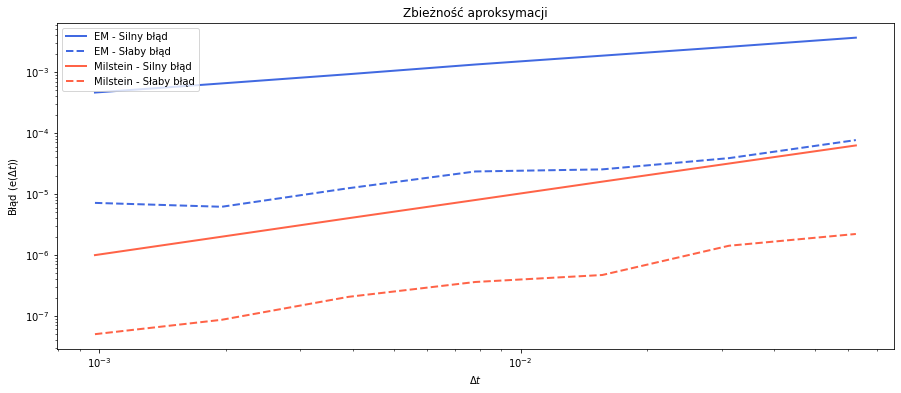

In [13]:
# Wykres błędów
plt.loglog(dt_grid, str_err_em, label="EM - Silny błąd",color='royalblue')
plt.loglog(dt_grid, weak_err_em, label="EM - Słaby błąd",color='royalblue',ls='--')
plt.loglog(dt_grid, str_err_mil, label="Milstein - Silny błąd",color='tomato')
plt.loglog(dt_grid, weak_err_mil, label="Milstein - Słaby błąd",color='tomato',ls='--')
plt.title('Zbieżność aproksymacji')
plt.xlabel('$\Delta t$'); plt.ylabel('Błąd (e($\Delta t$))')
plt.legend(loc=2);

Ogólna zależność na powyższym wykresie pokazuje, że silne i słabe błędy rosną wraz z $\Delta t$, co sugeruje, że obie aproksymację są silnie i słabo zbieżne, co jest pozytywnym rezultatem. Należy również zwrócić uwagę, na to, że słabe błędy (linie przerywane) są zawsze niżej niż silne błędy. Widzimy również, że silne błędy Milsteina są mniejsze niż słabe błędy E-M. Sugerował to już wykres wcześniej, który pokazał, że linia aproksymacji Milsteina była generalnie bliższa dokładnemu rozwiązaniu. Możemy również z grubsza zobaczyć, że nachylenie silnego błędu Milsteina wydaje się być większe niż nachylenie silnego błędu E-M, co oznacza szybsze tempo zbieżności (błąd szybciej zanika).

## Przedziały ufności

Na koniec, istotnym celem naszej pracy jest możliwość predykcji cen akcji w przyszłości. Dlatego też, dla sprawdzenia jakości modelu, stwórzmy predziały ufności na poziomie 95% i przetestujmy, czy cena akcji AAPL za równy rok "wpada" w ten przedział. Wiemy, że w przypadku zmiennej losowej o rozkładzie normalnym istnieje 95% prawdopodobieństwo, że jakakolwiek wartość mieści się w przedziale od 1,96 do -1,96 odchylenia standardowego jej średniej co wykorzystamy w kodzie poniżej.

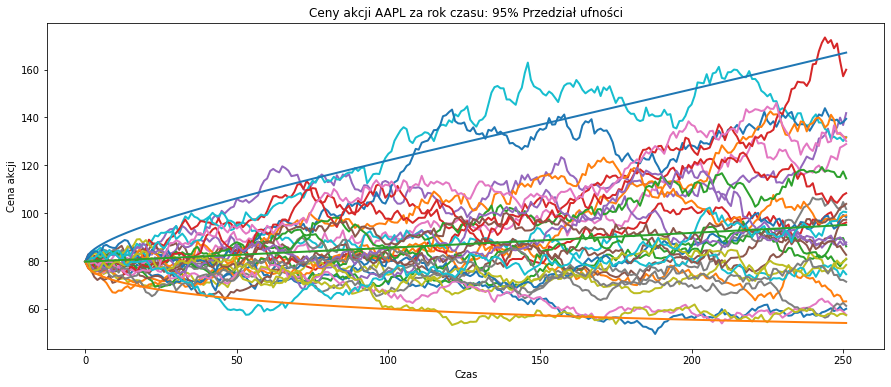

Ceny akcji AAPL za rok
Dolna granica 54.09    Górna granica 167.09    Oczekiwana cena 95.07


In [14]:
from scipy.stats import norm
n_simulations = 30
days = np.arange(252)

epsilon = norm.ppf(np.random.rand(len(days), n_simulations))
returns = drift - 0.5*sigma**2 + sigma * epsilon
returns_interval_1 = np.zeros(len(days))
returns_interval_2 = np.zeros(len(days))
expected_returns = np.zeros(len(days))

for t in range(1, len(days)):
  returns_interval_1[t] = (drift - 0.5*sigma**2)*(t-days[0]) + sigma *1.96*np.sqrt(t - days[0])
  returns_interval_2[t] = (drift - 0.5*sigma**2)*(t-days[0]) + sigma *-1.96*np.sqrt(t - days[0])

S = np.zeros_like(returns)
S_interval_1 = np.zeros_like(returns_interval_1)
S_interval_2 = np.zeros_like(returns_interval_2)
S_interval_1[0] = X0
S_interval_2[0] = X0
S[0] = X0
expected_returns[0] = X0


for t in range(1, len(days)):
    S[t] = S[t-1]*np.exp(returns[t])
    S_interval_1[t] = X0*np.exp(returns_interval_1[t])
    S_interval_2[t] = X0*np.exp(returns_interval_2[t])
    expected_returns[t] = expected_returns[t-1]*np.exp(average_return)

plt.rcParams['figure.figsize'] = (15,6)
plt.plot(S)
plt.plot(S_interval_1)
plt.plot(S_interval_2)
plt.plot(expected_returns)
plt.title('Ceny akcji AAPL za rok czasu: 95% Przedział ufności')
plt.xlabel('Czas')
plt.ylabel('Cena akcji')
plt.show()
print('Ceny akcji AAPL za rok')
print("Dolna granica", S_interval_2[251].round(2), "   Górna granica", S_interval_1[251].round(2), "   Oczekiwana cena", expected_returns[251].round(2))

Widzimy, że nasz zakres przewidywanych cen jest dosyć szeroki przy 95% przedziale ufności. Jako że ostatnie odnotowanie mamy z 22 maja 2020 roku, została sprawdzona cena dla 21 maja 2021 roku i wynosiła 125.43\$. Zatem cena akcji  leży w naszym przedziale ufności, co nas zadowala, oraz zdecydowanie powyżej oczekiwanej ceny. Można się zastanawiać co jest powodem takiego wyniku, lecz należy wziąć pod uwagę fakt, że wykonywane predykcje mają miejsce w okresie pandemii, która niosła ze sobą nieprzewidywalne wyniki. Widać jednak, że ten model zachowuje się dobrze, gdy ma za zadanie prognozować długoterminowo.

## Podsumowanie

Zastosowaliśmy numeryczne aproksymacje Eulera-Maruyamy i Milsteina do geometrycznego ruchu Browna i pokazaliśmy na przykładzie własności zbieżności każdego z nich. Finalnie, zgodnie z założeniem, aproksymacja Milsteina okazała się lepsza od aproksymacji E-M - lepiej przybliżała rozwiązanie dokładne naszego równania oraz miała szybsze tempo zbieżności. Na koniec zdecydowaliśmy się na przetestowanie jakości predykcji naszego modelu. Podjeliśmy się konstrukcji przedziału ufności na poziomie 95% i sprawdziliśmy, czy cena akcji za rok będzie się mieścić w tym przedziale. Wynik był pozytywny, zatem model mogliśmy uznać za poprawny.